In [1]:
import numpy as np
import numpy.polynomial as npp
import matplotlib.pyplot as plt
import scipy.signal as sps

# # Diseño de filtro Chebyshev Pasa Bajas

## Paola Briseño, UAM - I, 2022.

Diseño y simulación (teórico/SPICE) de un filtro pasa-bajas.

In [2]:
#Especificación relativa de pasabajas
Ap, Ar, fp, fr = 0.3, 30, 20000, 50000

In [3]:
#Parámetros Chebyshev
e = np.sqrt(10**(Ap/10)-1)
N = np.ceil(np.arccosh(np.sqrt((10**(Ar/10)-1)/(10**(Ap/10)-1)))/np.arccosh(fr/fp)).astype('int')
if Ap <= 3:
  fc = fp*np.cosh(np.arccosh(1/np.sqrt(10**(Ap/10)-1))/N)
else:
  fc = fp*np.cos(np.arccos(1/np.sqrt(10**(Ap/10)-1))/N)
  
# Muestra resultados
print(f'Chebyshev: \t N ={N:3d} \t fc = {fc:6.2f} Hz \t e = {e:6.4f}')

Chebyshev: 	 N =  4 	 fc = 22536.03 Hz 	 e = 0.2674


In [4]:
#Calculo de la respuesta en frecuencia
f = np.logspace(-2, 2, 1000)*fp

# Polinomio
T = npp.Chebyshev(N*[0]+[1])
H = -10*np.log10(1+(e*T(f/fp))**2)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


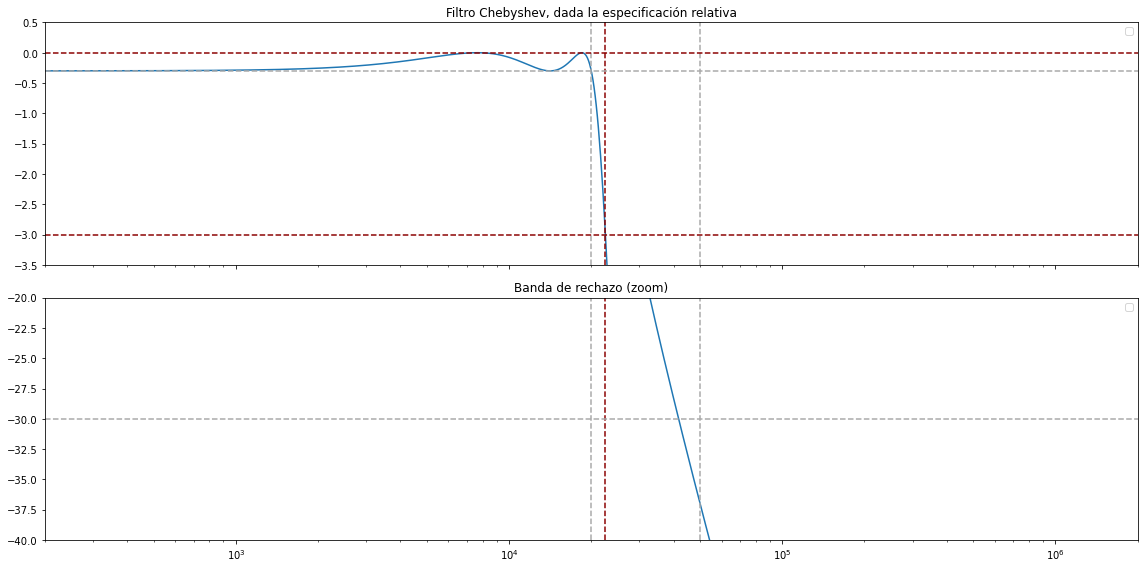

In [5]:
# Grafica la respuesta en frecuencia
fig, ax = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

# Respuesta en frecuencia (banda de paso)
ax[0].semilogx(f, H)
# Marcas relevantes
for v, c in [(fp, 'darkgray'), (fr, 'darkgray'), (fc, 'darkred')]:
  ax[0].axvline(v, linestyle='--', color=c)
for h, c in [(0, 'darkred'), (-Ap, 'darkgray'), (-Ar, 'darkgray'), (-3, 'darkred')]:
  ax[0].axhline(h, linestyle='--', color=c)
ax[0].axis([f[0], f[-1], min(-Ap, -3)-0.5, 0.5])
ax[0].set_title('Filtro Chebyshev, dada la especificación relativa')
ax[0].legend()

# Respuesta en frecuencia (banda de rechazo)
ax[1].semilogx(f, H)
# Marcas relevantes
for v in [fp, fr]:
  plt.axvline(v, linestyle='--', c='darkgray')
for v in [fc]:
  plt.axvline(v, linestyle='--', c='darkred')
for h in [0, -Ap, -Ar, -3]:
  plt.axhline(h, linestyle='--', c='darkgray')
plt.axis([f[0], f[-1], -Ar-10, -Ar+10])
plt.title('Banda de rechazo (zoom)')
plt.legend()
fig.tight_layout();

In [6]:
#Determinación de la función de transferencia pasabaja normalizada y factorizada
# Calculo polos Chebyshev
k = np.arange(0, 2*N)
a = (1/N)*np.arcsinh(1/e)
p = np.sin((2*k+1)*np.pi/(2*N))*np.sinh(a)+1j*np.cos((2*k+1)*np.pi/(2*N))*np.cosh(a)
p = np.sort_complex(p[p.real<=0])

# Secciones Chebyshev - denominadores
A = [np.real(np.poly(p[i:i+2])) for i in range(N%2, N, 2)]
if N%2:
  A.append(np.array([1, -np.real(p[0])]))
# Secciones Chebyshev
if N%2:
  SOST = [(np.array([D[-1]]), D) for D in A]
else:
  G = np.sqrt(1/(1+e**2))**(1/len(A))
  SOST = [(G*np.array([D[-1]]), D) for D in A]
  
# Muestra secciones
print('Secciones Chebyshev (B, A): ')
for sos in SOST:
  print(sos)

Secciones Chebyshev (B, A): 
(array([0.41942015]), array([1.        , 0.9782302 , 0.42672618]))
(array([1.11442047]), array([1.        , 0.40519622, 1.13383296]))


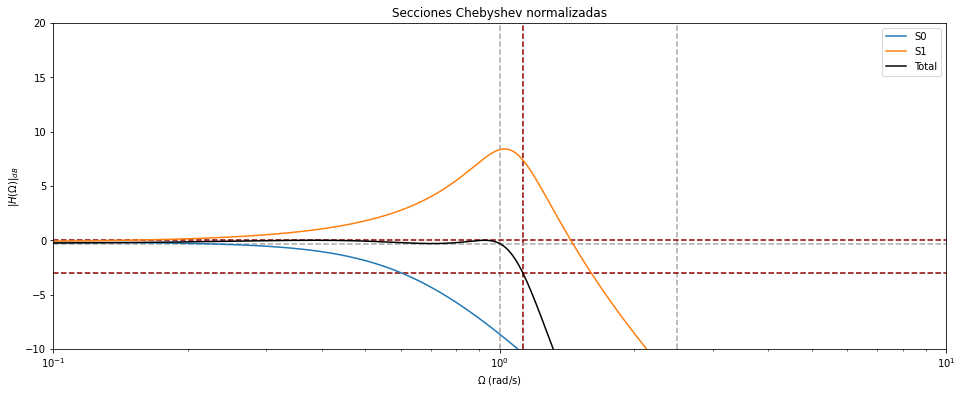

In [7]:
# Grafica respuestas en frecuencia por sección
plt.figure(figsize=(16, 6))
W = np.linspace(0.1, 10, 10000)
Ht = np.ones_like(W)

# Marcas relevantes
for v, c in [(1, 'darkgray'), (fr/fp, 'darkgray'), (fc/fp, 'darkred')]:
  plt.axvline(v, linestyle='--', color=c)
for h, c in [(0, 'darkred'), (-Ap, 'darkgray'), (-Ar, 'darkgray'), (-3, 'darkred')]:
  plt.axhline(h, linestyle='--', color=c)

# Secciones
for i, sos in enumerate(SOST):
  _, H = sps.freqs(sos[0], sos[1], W)
  Ht = Ht*H
  plt.semilogx(W, 20*np.log10(abs(H)), label=f'S{i}')
  
# Respuesta total
plt.semilogx(W, 20*np.log10(abs(Ht)), color='black', label='Total')
plt.axis([0.1, 10, -10, 20])
plt.xlabel('$\Omega$ (rad/s)')
plt.ylabel('$\|H(\Omega)\|_{dB}$')
plt.title('Secciones Chebyshev normalizadas')
plt.legend();

In [8]:
# Tranformación al pasa-banda real (desnormalización)
def npb2pbd(secciones, bw, Wc):
  """
  Transformación pasa-bajas a pasa-banda
  """
  secciones_transformadas = []
  for B, A in secciones:
      if A.shape[0] == 3:
        Bt = np.array([np.sqrt(B[0])*bw, 0])
        p = np.sort_complex(np.roots(np.array([A[0], A[1]*bw, 2*(A[0]*(Wc**2)) + A[2]*(bw**2), A[1]*(bw*(Wc**2)), A[0]*(Wc**4)])))
        At1 = np.real(np.poly(p[0:2]))
        At2 = np.real(np.poly(p[2:4]))
        secciones_transformadas.append((Bt, At1))
        secciones_transformadas.append((Bt, At2))
      else:
        Bt = np.array([B[0]*bw, 0])
        At = np.array([A[0], A[1]*bw, A[0]*(Wc**2)])
        secciones_transformadas.append((Bt, At))
  return secciones_transformadas

In [9]:
# Parámetros pasa-banda
fl, fh = 1000, 1500 ##modif?

# Mapeo de las frecuencias de diseño
B = 2*np.pi*(fh-fl)
Wc = 2*np.pi*np.sqrt(fl*fh)
fp1 = ((fp/fc)*B+np.sqrt(((fp/fc)*B)**2+4*(Wc**2)))/(4*np.pi)
fp2 = ((-fp/fc)*B+np.sqrt(((fp/fc)*B)**2+4*(Wc**2)))/(4*np.pi)
fr1 = ((fr/fc)*B+np.sqrt(((fr/fc)*B)**2+4*(Wc**2)))/(4*np.pi)
fr2 = ((-fr/fc)*B+np.sqrt(((fr/fc)*B)**2+4*(Wc**2)))/(4*np.pi)

# Anchos de banda
bwT = 2*np.pi*(fp2-fp1)

# Pasa-banda
SOSTbp = npb2pbd(SOST, bwT, Wc)

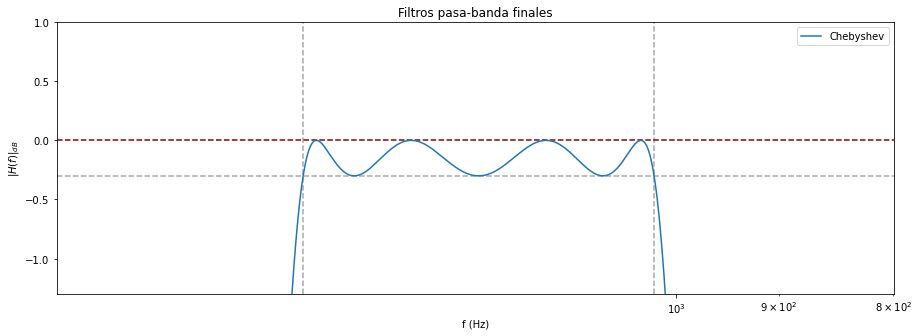

In [10]:
# Grafica respuestas en frecuencia finales
plt.figure(figsize=(15, 5))
f = np.linspace(0.1, 10, 100000)*Wc #modif??

# Marcas relevantes
for v, c in [(fp1, 'darkgray'), (fp2, 'darkgray'), (fr1, 'darkgray'), (fr2, 'darkgray')]:
  plt.axvline(v, linestyle='--', color=c)
for h, c in [(0, 'darkred'), (-Ap, 'darkgray'), (-Ar, 'darkgray'), (-3, 'darkred')]:
  plt.axhline(h, linestyle='--', color=c)
  
# Calcula y grafica la respuesta en frecuencia
for SOS, nombre in zip([SOSTbp], ['Chebyshev']):
  Ht = np.ones_like(f)
  for B, A in SOS:
    _, H = sps.freqs(B, A, 2*np.pi*f)
    Ht = Ht*H
  plt.semilogx(f, 20*np.log10(abs(Ht)), label=nombre)
plt.axis([fr1-10, fr2+10, -Ap-1, 1])
plt.xlabel('f (Hz)')
plt.ylabel('$\|H(f)\|_{dB}$')
plt.title('Filtros pasa-banda finales')
plt.legend();

#Implementación del filtro, netlist
